# Install Dependencies

##whisper for transcribing audio

In [12]:
!pip install git+https://github.com/openai/whisper.git
# !sudo apt update && sudo apt install ffmpeg   #run in terminal

  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-bntftf7l
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-bntftf7l
  Resolved https://github.com/openai/whisper.git to commit c0d2f624c09dc18e709e37c2ad90c039a4eb72a2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached triton-3.5.1-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (1.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.5/170.5 MB 6.6 MB/s eta 0:00:00
  Created wheel for openai-whisper: filename=openai_whisper-20250625-py3-none-any.whl size=803979 sha256=0f82323ae95184bb7f4a5479aeed0100d336b789187d4237cd8e4d6a5964b661
  Stored in directory: /tmp/pip-ephem-wheel-cache-_xzx7clc/wheels/c3/03/25/5e0ba78bc27a3a089f137c9f1d92fdfce16d06996c071a016c
Successfully built openai-whisper


In [2]:
#!whisper -h

## Code for recording audio in colab

In [3]:
from google.colab import output
output.enable_custom_widget_manager()

In [4]:
!pip install ipywidgets

import ipywidgets as widgets
from IPython.display import display, Audio
from google.colab import output
import numpy as np
import io
import base64

# Create start and stop buttons
start_button = widgets.Button(description="Start Recording")
stop_button = widgets.Button(description="Stop Recording")

recording = False

# Function to start recording
def start_recording(b):
    global recording
    recording = True
    output.eval_js('startRecording()')
    print("Recording started...")

# Function to stop recording and save the file
def stop_recording(b):
    global recording
    if not recording:
        print("No recording in progress.")
        return

    recording = False
    audio_data = output.eval_js('stopRecording()')

    if audio_data is None:
        print("No audio data recorded.")
        return

    # Decode base64 data
    audio_bytes = base64.b64decode(audio_data['audio'])

    # Create and display Audio widget
    audio_obj = Audio(data=audio_bytes, rate=audio_data['sampleRate'])
    display(audio_obj)

    # Save as WAV file
    with open("recorded_audio.wav", "wb") as f:
        f.write(audio_bytes)

    print("Audio saved as 'recorded_audio.wav'")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.3 MB/s eta 0:00:00


In [13]:
#record invoice
# Connect buttons to functions
start_button.on_click(start_recording)
stop_button.on_click(stop_recording)

# Display buttons
display(start_button, stop_button)

# JavaScript to handle audio recording
output.eval_js('''
    let recorder, stream;

    async function startRecording() {
        stream = await navigator.mediaDevices.getUserMedia({ audio: true });
        recorder = new MediaRecorder(stream);
        chunks = [];
        recorder.ondataavailable = e => chunks.push(e.data);
        recorder.start();
    }

    function stopRecording() {
        return new Promise(resolve => {
            recorder.onstop = () => {
                const blob = new Blob(chunks, { type: 'audio/wav' });
                chunks = [];
                stream.getTracks().forEach(track => track.stop());
                const reader = new FileReader();
                reader.onload = () => {
                    const base64data = reader.result.split(',')[1];
                    resolve({audio: base64data, sampleRate: 44100});
                };
                reader.readAsDataURL(blob);
            };
            recorder.stop();
        });
    }
''')

Button(description='Start Recording', style=ButtonStyle())

Button(description='Stop Recording', style=ButtonStyle())

Recording started...


Audio saved as 'recorded_audio.wav'


## Langchain & langgraph pip installs

In [6]:
%%capture --no-stderr
%pip install -U  langgraph langgraph_tavily wikipedia langchain_openai langchain_community langgraph_sdk

In [7]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph langgraph-prebuilt

In [8]:
pip install -U langchain-tavily

## Setting all API keys

In [9]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

OPENAI_API_KEY: ··········


In [10]:
import os, getpass
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")
_set_env("TAVILY_API_KEY")

TAVILY_API_KEY: ··········


Here, we'll use LangSmith for tracing.

We'll log to a project, langchain-academy.

In [11]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "Dreamjournal-Agent"

LANGSMITH_API_KEY: ··········


#Langchain agent

In [22]:
from langchain_openai import ChatOpenAI
import whisper
import time
from IPython.display import display
from langchain_tavily import TavilySearch



def transcribe(audio_path: str) -> str:
    """Transcribe an audio file using Whisper Python API.

    if record_audio has been used in session and user asks for transcription the path to the audio file is /content/recorded_audio.wav otherwise use specific path that user provides.

    after returning the transcription ask the user: to reread it and point out mistakes like names being wrong transcribed etc.


    Args:
        audio_path: Path to the audio file.

    Returns:
        The transcription as a string.

    """

    print("transcribing right now..")

    # Load the model
    model = whisper.load_model("medium.en")

    # Transcribe the audio
    result = model.transcribe(audio_path)

    # Return the text only
    return result["text"]


def record_audio() -> str:
    """
    Displays the audio recording UI for the user.
    The user must record audio manually.
    The file will be saved as recorded_audio.wav.

    after ask the user when its done recording if it want to transcribe it the it can ask for that.
    """

    #record invoice
    # Connect buttons to functions
    start_button.on_click(start_recording)
    stop_button.on_click(stop_recording)

    # Display buttons
    display(start_button, stop_button)

    # JavaScript to handle audio recording
    output.eval_js('''
        let recorder, stream;

        async function startRecording() {
            stream = await navigator.mediaDevices.getUserMedia({ audio: true });
            recorder = new MediaRecorder(stream);
            chunks = [];
            recorder.ondataavailable = e => chunks.push(e.data);
            recorder.start();
        }

        function stopRecording() {
            return new Promise(resolve => {
                recorder.onstop = () => {
                    const blob = new Blob(chunks, { type: 'audio/wav' });
                    chunks = [];
                    stream.getTracks().forEach(track => track.stop());
                    const reader = new FileReader();
                    reader.onload = () => {
                        const base64data = reader.result.split(',')[1];
                        resolve({audio: base64data, sampleRate: 44100});
                    };
                    reader.readAsDataURL(blob);
                };
                recorder.stop();
            });
        }
    ''')

    return (
        #"Audio recording UI displayed. "
        #"Please click Start Recording, then Stop Recording. "
        #"The file will be saved as recorded_audio.wav."
        "Audio record tool successfully called"
    )

def search_web(question: str) -> str:
    """Retrieve information from web search using a question string."""

    print("Searching online...")

    tavily_search = TavilySearch(max_results=3)
    data = tavily_search.invoke({"query": question})
    search_docs = data.get("results", data)

    formatted_search_docs = "\n\n---\n\n".join(
        f'<Document href="{doc["url"]}">\n{doc["content"]}\n</Document>'
        for doc in search_docs
    )

    return formatted_search_docs

tools = [transcribe, record_audio,search_web]
llm = ChatOpenAI(model="gpt-4o")


llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

In [15]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked using a tool to transcribe audio or use a tool that the user can use to record audio, when the user uses record audio you can finish the session. You can also search info online")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

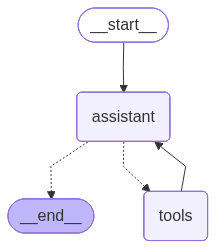

In [16]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [17]:
#code used for creating chat memory
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

In [18]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [HumanMessage(content="can I transcribe my dream?")]

# Run
messages = react_graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

can I transcribe my dream?
================================== Ai Message ==================================

You can transcribe your dream by either recording it and then requesting a transcription, or if you have an audio file of your dream already, you can provide the path to that file for transcription. How would you like to proceed?


In [19]:
messages = [HumanMessage(content=" I don't have an audio yet yes I want to record one")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

Button(description='Start Recording', style=ButtonStyle())

Button(description='Stop Recording', style=ButtonStyle())

================================ Human Message =================================

can I transcribe my dream?
================================== Ai Message ==================================

You can transcribe your dream by either recording it and then requesting a transcription, or if you have an audio file of your dream already, you can provide the path to that file for transcription. How would you like to proceed?
================================ Human Message =================================

 I don't have an audio yet yes I want to record one
================================== Ai Message ==================================
Tool Calls:
  record_audio (call_wwVqIeh4pX07i4N9tTRlQjOF)
 Call ID: call_wwVqIeh4pX07i4N9tTRlQjOF
  Args:
================================= Tool Message =================================
Name: record_audio

Audio record tool successfully called
================================== Ai Message ==================================

You can start recording your audio n

Audio saved as 'recorded_audio.wav'


In [20]:
messages = [HumanMessage(content=" okay can you transcribe my dream")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

transcribing right now..


100%|█████████████████████████████████████| 1.42G/1.42G [01:01<00:00, 24.8MiB/s]
/usr/local/lib/python3.12/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


================================ Human Message =================================

can I transcribe my dream?
================================== Ai Message ==================================

You can transcribe your dream by either recording it and then requesting a transcription, or if you have an audio file of your dream already, you can provide the path to that file for transcription. How would you like to proceed?
================================ Human Message =================================

 I don't have an audio yet yes I want to record one
================================== Ai Message ==================================
Tool Calls:
  record_audio (call_wwVqIeh4pX07i4N9tTRlQjOF)
 Call ID: call_wwVqIeh4pX07i4N9tTRlQjOF
  Args:
================================= Tool Message =================================
Name: record_audio

Audio record tool successfully called
================================== Ai Message ==================================

You can start recording your audio n

In [21]:
messages = [HumanMessage(content=" can you search online what the meaning of this dream could be?")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

can I transcribe my dream?
================================== Ai Message ==================================

You can transcribe your dream by either recording it and then requesting a transcription, or if you have an audio file of your dream already, you can provide the path to that file for transcription. How would you like to proceed?
================================ Human Message =================================

 I don't have an audio yet yes I want to record one
================================== Ai Message ==================================
Tool Calls:
  record_audio (call_wwVqIeh4pX07i4N9tTRlQjOF)
 Call ID: call_wwVqIeh4pX07i4N9tTRlQjOF
  Args:
================================= Tool Message =================================
Name: record_audio

Audio record tool successfully called
================================== Ai Message ==================================

You can start recording your audio n